In [1]:
import openai

import pandas as pd
import ast
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np
import math
import re
import csv
import os

from scipy.stats import ttest_rel, ttest_ind
import numpy as np

from benchmark_utils import list_files

In [68]:
colours = {
    "Comprehensiveness": "#6497b1",
    "Correctness": "#b3cde0",
    "Usefulness": "#005b96",
    "Interpr./Expl.": "#03396c",
    "Toxicity": "#011f4b",
    "None": "#eaaacc",
    "Simple w/o flattery": "#e492b6",
    "Simple w flattery": "#e58996",
    "Req. included": "#db6480",
    "Explicit Req.": "#701f62",
    "Young": "#a0d6b4",
    "Mid-Age\nPregeriatric": "#5f9ea0",
    "Geriatric": "#317873",
    "Plain": "#ff835a",
    "Emotional": "#ffb69e",
    "List Style": "#a989c4",
    "Freetext Style": "#5f447b",
    "No Appendix": "#b58174",
    "Appendix": "#7b5146",
    "cautious": "#e30744",
    "definitive": "#6db7c6",
}

model_mapping = {
    "llama-3.2-3b-instruct": "Llama 3.2 3B",
    "qwen2.5-14b-instruct": "Qwen 2.5 14B",
}

metric_mapping = {
    "correctness": "Correctness",
    "comprehensiveness": "Comprehensiveness",
    "usefulness": "Usefulness",
    "interpretability_explainability": "Interpr./Expl.",
    "toxicity": "Toxicity",
}

prompt_mapping = {
    "none": "None",
    "simple_without_flattery": "Simple w/o flattery",
    "simple_with_flattery": "Simple w flattery",
    ":requirements": "Req. included",
    "explicit_requirements": "Explicit Req.",
}

subtask_mapping = {
    "plain": "Plain",
    "emotional": "Emotional",
    "no_appendix": "No Appendix",
    ":appendix": "Appendix",
    "list": "List Style",
    ":freetext": "Freetext Style",
}

age_mapping = {
    "young": "Young",
    "geriatric": "Geriatric",
    "mid-aged/pregeriatric": "Mid-Age\nPregeriatric",
}

In [3]:
df = pd.read_csv("/Users/u018480/Desktop/Projects/biochatter/benchmark/results/judge_responses.csv")
df.head()

,model_name,evaluated_model,iterations,metric,case_id,subtask,age,md5_hash,prompt,system_prompt,prompt_type,is_appendix,responses,expected_answer,rating
0,gpt-4o-mini-2024-07-18,llama-3.2-3b-instruct,4,comprehensiveness,2,rag:longevity:active_nurse:emotional:freetext:...,young,52ce1ee7774e55f5b18d84e22d440a0a,I’ve been thinking for a while about improving...,explicit_requirements,freetext,appendix,"[""Based on the information provided, you are a...",yes,1.0;1.0/1
1,gpt-4o-mini-2024-07-18,llama-3.2-3b-instruct,4,comprehensiveness,2,rag:longevity:active_nurse:emotional:freetext:...,young,730ca1fbd7cb274826bd05af85f14b52,I’ve been thinking for a while about improving...,none,freetext,appendix,"[""Based on the provided information, you are a...",yes,0.75;1.0/1
2,gpt-4o-mini-2024-07-18,llama-3.2-3b-instruct,4,comprehensiveness,2,rag:longevity:active_nurse:emotional:freetext:...,young,8d1db6b3d1737d513738d9998542bb42,I’ve been thinking for a while about improving...,requirements,freetext,appendix,"[""Based on the information provided, you are a...",yes,0.0;0.0/1
3,gpt-4o-mini-2024-07-18,llama-3.2-3b-instruct,4,comprehensiveness,2,rag:longevity:active_nurse:emotional:freetext:...,young,2a7e0862bef6bdc19b4a5ad952f823ff,I’ve been thinking for a while about improving...,simple_with_flattery,freetext,appendix,"['Final answer: no', 'Final answer: no']",yes,0.0;0.0/1
4,gpt-4o-mini-2024-07-18,llama-3.2-3b-instruct,4,comprehensiveness,2,rag:longevity:active_nurse:emotional:freetext:...,young,e5d7c77a0cd026211824eb69ccc4dd06,I’ve been thinking for a while about improving...,simple_without_flattery,freetext,appendix,"['Final answer: no. ', 'Final answer: no. ']",yes,0.0;0.0/1


In [4]:
def score_helper(df):
    if df.empty:
        print("Input DataFrame is empty!")
        return None, None, None
    
    raw_results = df.copy()
    
    # Ensure valid `rating` values
    raw_results["rating"] = raw_results["rating"].fillna("0/1")
    raw_results["rating"] = raw_results["rating"].apply(
        lambda x: x if "/" in x else "0/1"
    )
    
    # Calculate scores
    raw_results["score_possible"] = raw_results["rating"].apply(
        lambda x: float(x.split("/")[1])
    )
    raw_results["scores"] = raw_results["rating"].apply(
        lambda x: x.split("/")[0]
    )
    raw_results["score_achieved_total"] = raw_results["scores"].apply(
        lambda x: np.sum([float(score) for score in x.split(";")])
    )
    raw_results["iteration_scores"] = raw_results["scores"].apply(
        lambda x: [float(score) for score in x.split(";")]
    )
    raw_results["iteration_index"] = raw_results["iteration_scores"].apply(
        lambda x: list(range(1, len(x) + 1))
    )

    # Explode iteration scores and indexes
    exploded_results = raw_results.explode(["iteration_scores", "iteration_index"])
    exploded_results["iteration_scores"] = exploded_results["iteration_scores"].astype(float)
    exploded_results["iteration_index"] = exploded_results["iteration_index"].astype(int)

    # Aggregate per iteration
    aggregated_results_iteration = exploded_results.groupby(["evaluated_model", "iteration_index"]).agg(
        score_possible=("score_possible", "sum"),
        score_achieved_total=("iteration_scores", "sum"),
    ).reset_index()

    aggregated_results_iteration["score"] = aggregated_results_iteration["score_achieved_total"] / aggregated_results_iteration["score_possible"]

    # Aggregate overall
    aggregated_scores = raw_results.groupby(["evaluated_model"]).agg(
        score_possible=("score_possible", "sum"),
        score_achieved_total=("score_achieved_total", "sum"),
        iterations=("iterations", "first")
    ).reset_index()

    # Validate raw_results shape
    if raw_results.shape[1] < 3:
        raise ValueError("raw_results does not have the required number of columns.")

    # Final score calculations
    # aggregated_scores['score_possible_total'] = aggregated_scores['score_possible'] * raw_results.iloc[:, 2].iloc[0]
    aggregated_scores['score_possible_total'] = aggregated_scores['score_possible'] * 2
    aggregated_scores['score_achieved_avg'] = aggregated_scores['score_achieved_total'] / raw_results.iloc[:, 2].iloc[0]

    score = aggregated_scores["score_achieved_total"] / aggregated_scores["score_possible_total"]
    aggregated_scores["score"] = score

    std_results = aggregated_results_iteration.groupby(["evaluated_model"])["score"].std().reset_index()
    aggregated_scores['score_achieved_std'] = std_results.iloc[:, 1]

    return exploded_results, raw_results, aggregated_scores, aggregated_results_iteration, std_results


In [5]:
score_helper(df[(df["is_appendix"] == "no_appendix") & (df["metric"] == "usefulness") & (df["age"].str.startswith("geriatric")) & (df["subtask"].str.contains("freetext"))])[2]

,evaluated_model,score_possible,score_achieved_total,iterations,score_possible_total,score_achieved_avg,score,score_achieved_std
0,llama-3.2-3b-instruct,40.0,30.5,4,80.0,7.625,0.38125,0.017678
1,qwen2.5-14b-instruct,20.0,13.5,4,40.0,3.375,0.33750,0.017678


In [6]:
score_helper(df[(df["metric"] == "correctness") & (df["subtask"].str.contains("none"))])[3]

,evaluated_model,iteration_index,score_possible,score_achieved_total,score
0,llama-3.2-3b-instruct,1,96.0,54.75,0.570312
1,llama-3.2-3b-instruct,2,96.0,54.75,0.570312
2,qwen2.5-14b-instruct,1,48.0,32.00,0.666667
3,qwen2.5-14b-instruct,2,48.0,32.00,0.666667


In [7]:
def create_frames(df):
    models = list(df["evaluated_model"].unique())

    dfs = []
    for model in models:
        _ = df[df["evaluated_model"] == model]
        dfs.append(_)
    return dfs

In [14]:
def create_metric_frame(dfs, metrics, task_type):
    metric_dfs = []

    for df in dfs:
        metric_frames = []
        for metric in metrics:
            _ = score_helper(
                df[(df["metric"] == metric) &
                   (df["subtask"].str.startswith(task_type))],
            )[2]
            _["metric"] = metric
            metric_frames.append(_)
        metric_dfs.append(pd.concat(metric_frames))
    return metric_dfs

In [15]:
dfs = create_frames(df = df)
metric_dfs = create_metric_frame(
    dfs = dfs,
    metrics = [
        "correctness",
        "comprehensiveness",
        "usefulness",
        "interpretability_explainability",
        "toxicity",
    ],
    task_type = "longevity",
)

Bar 1: Height = 0.4891, Std = 0.0007
Bar 2: Height = 0.5542, Std = 0.0044
Bar 3: Height = 0.1969, Std = 0.0029
Bar 4: Height = 0.4276, Std = 0.0007
Bar 5: Height = 0.3219, Std = 0.0037
Bar 6: Height = 0.6406, Std = 0.0000
Bar 7: Height = 0.3568, Std = 0.0022
Bar 8: Height = 0.7328, Std = 0.0015
Bar 9: Height = 0.4005, Std = 0.0037
Bar 10: Height = 0.1219, Std = 0.0059


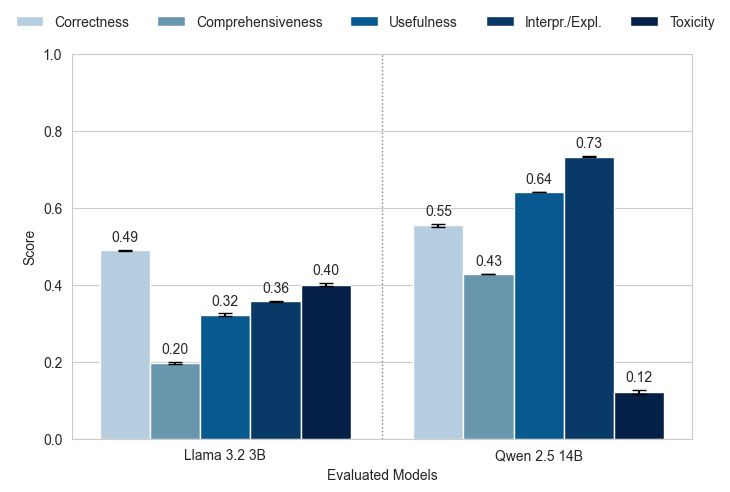

In [21]:
metric_df = pd.concat(metric_dfs)
metric_df["metric"] = metric_df["metric"].map(metric_mapping)
metric_df["evaluated_model"] = metric_df["evaluated_model"].map(model_mapping)

sns.set_style(style = "whitegrid")

plt.figure(figsize = (8, 5))
plot = sns.barplot(x = "evaluated_model", 
                   y = "score", 
                   hue = "metric", 
                   data = metric_df,
                   errorbar = ("sd"),
                   palette = colours, 
                   saturation = 0.9)

std_values = metric_df["score_achieved_std"].to_numpy()
for i, patch in enumerate(plot.patches[:len(std_values)]):
    std = std_values[i]
    extra = 0
    height = patch.get_height()
    print(f"Bar {i + 1}: Height = {height:.4f}, Std = {std:.4f}")
    if patch.get_height() > 0:
        plt.errorbar(x=patch.get_x() + patch.get_width() / 2,
                     y=patch.get_height(),
                     yerr=std,
                     fmt='none',
                     c='black',
                     capsize=5)
        plt.annotate(format(patch.get_height(), ".2f"),
                      (patch.get_x() + patch.get_width() / 2, min(patch.get_height() + std, 100) + extra),
                      ha = "center",
                      va = "center",
                      xytext = (0, 9),
                      textcoords = "offset points",
                      fontsize = 10)

models = metric_df["evaluated_model"].unique() 
for j in range(len(models) - 1):
    plot.axvline(x=j + 0.5, color="gray", linestyle=":", linewidth=1)

plt.legend(bbox_to_anchor = (-0.1, 1.05),
           loc = "lower left",
           ncols = len(metric_df["metric"].unique()),
           frameon = False,
           borderaxespad = 0.)

plt.ylabel("Score")
plt.xlabel("Evaluated Models")
plt.ylim(0, 1.0)
plt.show()

In [22]:
def create_sysprompt_frame(dfs, sys_prompts, metrics, task_type):
    sys_prompt_df = []

    for df in dfs:
        sys_prompt_frame = []
        for sys_prompt in sys_prompts:
            for metric in metrics:
                _ = score_helper(
                    df[(df["metric"] == metric) &
                       (df["subtask"].str.startswith(task_type)) &
                       (df["subtask"].str.contains(sys_prompt))],
                )[2]
                _["metric"], _["system_prompt"] = metric, sys_prompt
                sys_prompt_frame.append(_)
        sys_prompt_df.append(pd.concat(sys_prompt_frame))
    return sys_prompt_df

In [74]:
dfs = create_frames(df = df)
sys_prompt_dfs = create_sysprompt_frame(
    dfs = dfs,
    sys_prompts = [
        "none",
        "simple_without_flattery",
        "simple_with_flattery",
        ":requirements",
        "explicit_requirements",
    ],
    metrics = [
        "correctness",
        "comprehensiveness",
        "usefulness",
        "interpretability_explainability",
        "toxicity",
    ],
    task_type = "longevity",
)

Bar 1: Height = 0.4531, Std = 0.0000
Bar 2: Height = 0.0208, Std = 0.0000
Bar 3: Height = 0.0599, Std = 0.0037
Bar 4: Height = 0.0859, Std = 0.0037
Bar 5: Height = 0.1927, Std = 0.0147
Bar 6: Height = 0.4167, Std = 0.0000
Bar 7: Height = 0.2526, Std = 0.0037
Bar 8: Height = 0.3333, Std = 0.0000
Bar 9: Height = 0.3307, Std = 0.0037
Bar 10: Height = 0.5182, Std = 0.0110
Bar 11: Height = 0.5547, Std = 0.0037
Bar 12: Height = 0.2500, Std = 0.0000
Bar 13: Height = 0.4036, Std = 0.0037
Bar 14: Height = 0.4557, Std = 0.0037
Bar 15: Height = 0.4297, Std = 0.0037
Bar 16: Height = 0.5208, Std = 0.0000
Bar 17: Height = 0.2526, Std = 0.0184
Bar 18: Height = 0.3854, Std = 0.0074
Bar 19: Height = 0.4375, Std = 0.0000
Bar 20: Height = 0.4219, Std = 0.0000
Bar 21: Height = 0.5000, Std = 0.0000
Bar 22: Height = 0.2083, Std = 0.0000
Bar 23: Height = 0.4271, Std = 0.0000
Bar 24: Height = 0.4740, Std = 0.0074
Bar 25: Height = 0.4401, Std = 0.0037
Bar 1: Height = 0.6667, Std = 0.0000
Bar 2: Height = 0.4141

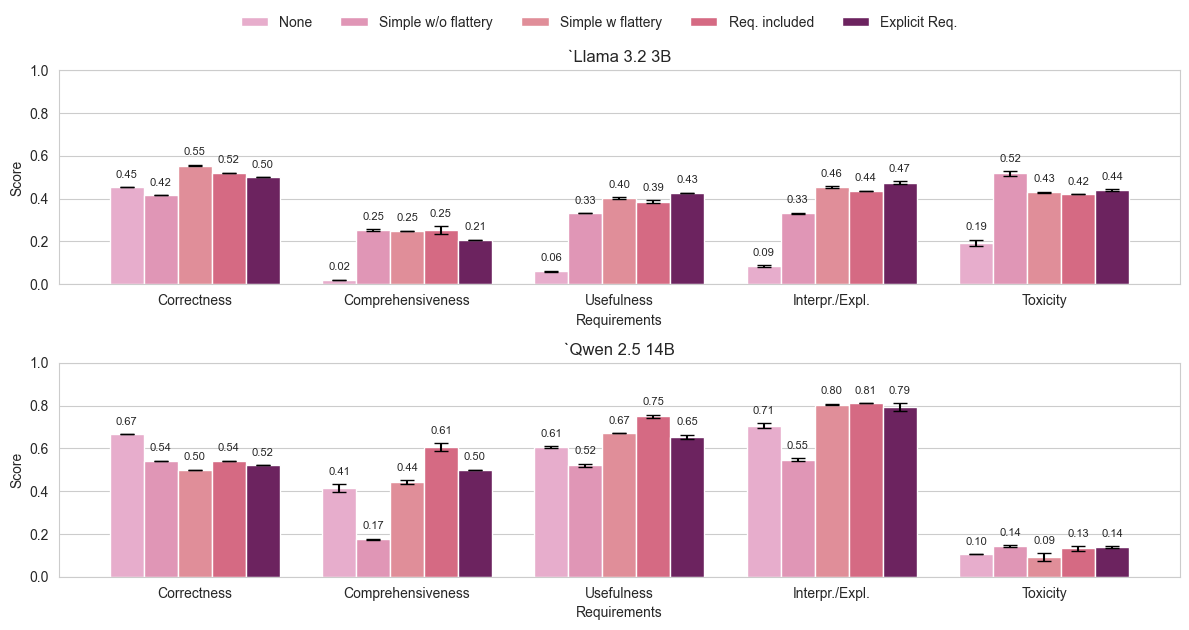

In [75]:
# sys_prompt_df = pd.concat(sys_prompt_dfs)

# sys_prompt_df["metric"] = sys_prompt_df["metric"].map(metric_mapping)

sns.set_style(style = "whitegrid")

# plt.figure(figsize = (8, 5))
fig, axes = plt.subplots(2, 1, figsize = (12, 6))

for ax, df_ in zip(axes, sys_prompt_dfs):
    df_["metric"] = df_["metric"].map(metric_mapping)
    df_["system_prompt"] = df_["system_prompt"].map(prompt_mapping)

    plot = sns.barplot(
        x = "metric", 
        y = "score", 
        hue = "system_prompt", 
        data = df_,
        errorbar = ("sd"),
        palette = colours, 
        saturation = 0.9,
        ax = ax,
    )

    std_values = df_["score_achieved_std"].to_numpy()
    for i, patch in enumerate(plot.patches[:len(std_values)]):
        std = std_values[i]
        extra = 0
        height = patch.get_height()
        print(f"Bar {i + 1}: Height = {height:.4f}, Std = {std:.4f}")
        if patch.get_height() > 0:
            ax.errorbar(x=patch.get_x() + patch.get_width() / 2,
                        y=patch.get_height(),
                        yerr=std,
                        fmt='none',
                        c='black',
                        capsize=5)
            ax.annotate(format(patch.get_height(), ".2f"),
                        (patch.get_x() + patch.get_width() / 2, min(patch.get_height() + std, 100) + extra),
                        ha = "center",
                        va = "center",
                        xytext = (0, 9),
                        textcoords = "offset points",
                        fontsize = 8)
    ax.set_ylim(0, 1)
    ax.set_ylabel("Score")
    ax.set_xlabel("Requirements")
    ax.legend().set_visible(False)

axes[0].set_title("`Llama 3.2 3B")
axes[1].set_title("`Qwen 2.5 14B")

handles, labels = plot.get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    bbox_to_anchor=(0.2, 1.0),
    loc="lower left",
    ncols=5,
    frameon=False,
    borderaxespad=0.0,
)

plt.tight_layout()
plt.show()

In [26]:
def create_age_frame(dfs, metrics, age_groups, task_type):
    age_dfs = []

    for df in dfs:
        age_frame = []
        for age_group in age_groups:
            for metric in metrics:
                _ = score_helper(
                    df[(df["metric"] == metric) &
                       (df["age"] == age_group) &
                       (df["subtask"].str.startswith(task_type))],
                )[2]
                _["metric"], _["age_group"] = metric, age_group
                age_frame.append(_)
        age_dfs.append(pd.concat(age_frame))
    return age_dfs

In [42]:
dfs = create_frames(df = df)
age_dfs = create_age_frame(
    dfs = dfs,
    metrics = [
        "correctness",
        "comprehensiveness",
        "usefulness",
        "interpretability_explainability",
        "toxicity",
    ],
    age_groups = [
        "young",
        "mid-aged/pregeriatric",
        "geriatric",
    ],
    task_type = "longevity",
)

Bar 1: Height = 0.4198, Std = 0.0015
Bar 2: Height = 0.2365, Std = 0.0044
Bar 3: Height = 0.3156, Std = 0.0015
Bar 4: Height = 0.3156, Std = 0.0015
Bar 5: Height = 0.5104, Std = 0.0029
Bar 6: Height = 0.4000, Std = 0.0000
Bar 7: Height = 0.3250, Std = 0.0000
Bar 8: Height = 0.3719, Std = 0.0044
Bar 9: Height = 0.3750, Std = 0.0000
Bar 10: Height = 0.5500, Std = 0.0000
Bar 11: Height = 0.6375, Std = 0.0000
Bar 12: Height = 0.0734, Std = 0.0066
Bar 13: Height = 0.3063, Std = 0.0088
Bar 14: Height = 0.4094, Std = 0.0044
Bar 15: Height = 0.1609, Std = 0.0066
Bar 1: Height = 0.5000, Std = 0.0000
Bar 2: Height = 0.6552, Std = 0.0015
Bar 3: Height = 0.8271, Std = 0.0000
Bar 4: Height = 0.9094, Std = 0.0044
Bar 5: Height = 0.0000, Std = 0.0000
Bar 6: Height = 0.7000, Std = 0.0000
Bar 7: Height = 0.5625, Std = 0.0000
Bar 8: Height = 0.9062, Std = 0.0000
Bar 9: Height = 0.9187, Std = 0.0000
Bar 10: Height = 0.0000, Std = 0.0000
Bar 11: Height = 0.5625, Std = 0.0000
Bar 12: Height = 0.0187, Std =

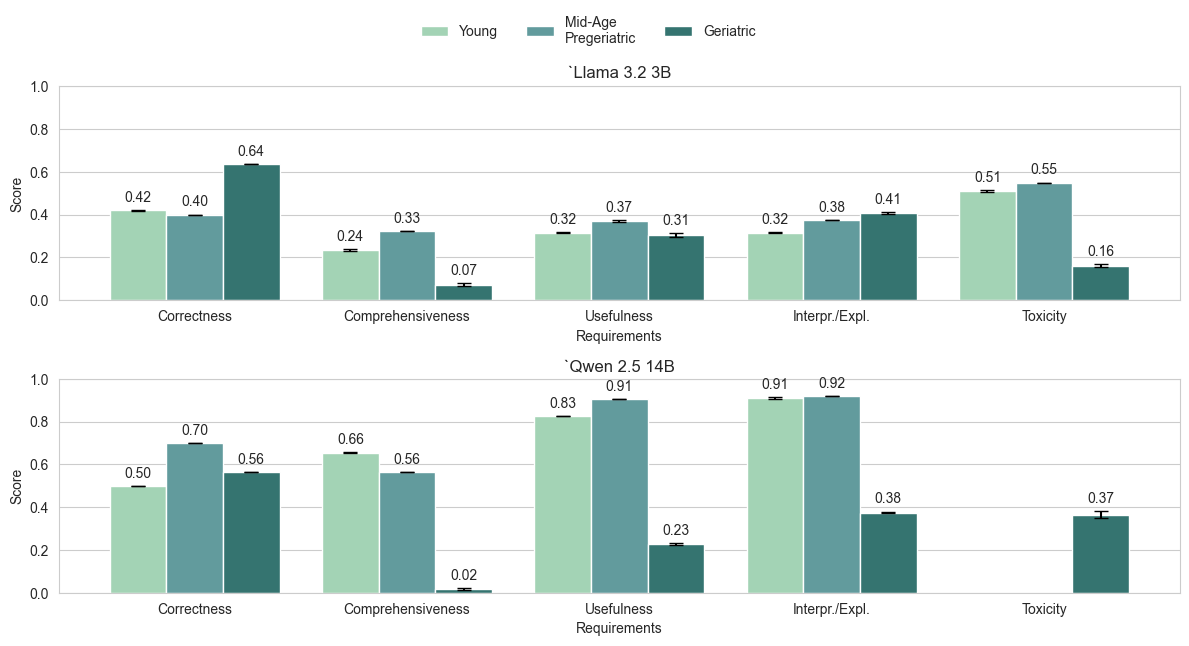

In [43]:
sns.set_style(style = "whitegrid")

# plt.figure(figsize = (8, 5))
fig, axes = plt.subplots(2, 1, figsize = (12, 6))

for ax, df_ in zip(axes, age_dfs):
    df_["metric"] = df_["metric"].map(metric_mapping)
    df_["age_group"] = df_["age_group"].map(age_mapping)

    plot = sns.barplot(
        x = "metric", 
        y = "score", 
        hue = "age_group", 
        data = df_,
        errorbar = ("sd"),
        palette = colours, 
        saturation = 0.9,
        ax = ax,
    )

    std_values = df_["score_achieved_std"].to_numpy()
    for i, patch in enumerate(plot.patches[:len(std_values)]):
        std = std_values[i]
        extra = 0
        height = patch.get_height()
        print(f"Bar {i + 1}: Height = {height:.4f}, Std = {std:.4f}")
        if patch.get_height() > 0:
            ax.errorbar(x=patch.get_x() + patch.get_width() / 2,
                        y=patch.get_height(),
                        yerr=std,
                        fmt='none',
                        c='black',
                        capsize=5)
            ax.annotate(format(patch.get_height(), ".2f"),
                        (patch.get_x() + patch.get_width() / 2, min(patch.get_height() + std, 100) + extra),
                        ha = "center",
                        va = "center",
                        xytext = (0, 9),
                        textcoords = "offset points",
                        fontsize = 10) 
    ax.set_ylim(0, 1)
    ax.set_ylabel("Score")
    ax.set_xlabel("Requirements")
    ax.legend().set_visible(False)

axes[0].set_title("`Llama 3.2 3B")
axes[1].set_title("`Qwen 2.5 14B")

handles, labels = plot.get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    bbox_to_anchor=(0.35, 1.0),
    loc="lower left",
    ncols=5,
    frameon=False,
    borderaxespad=0.0,
)

plt.tight_layout()
plt.show()

In [49]:
def create_extension_frame(dfs, primary_values, secondary_values, col_1, col_2, task_type):
    extension_dfs = []

    for df in dfs:
        extension_frame = []
        for prim_val in primary_values:
            for sec_val in secondary_values:
                _ = score_helper(
                    df[(df[col_1] == prim_val) &
                       (df[col_2].str.contains(sec_val)) &
                       (df[col_2].str.startswith(task_type))],
                )[2]
                _[col_1], _[col_2] = prim_val, sec_val
                extension_frame.append(_)
        extension_dfs.append(pd.concat(extension_frame))
    return extension_dfs

In [64]:
dfs = create_frames(df = df)
extension_dfs = create_extension_frame(
    dfs = dfs,
    primary_values = [
        "correctness",
        "comprehensiveness",
        "usefulness",
        "interpretability_explainability",
        "toxicity",
    ],
    secondary_values = [
        "emotional",
        "plain",
    ],
    col_1 = "metric",
    col_2 = "subtask",
    task_type = "longevity",
)

Bar 1: Height = 0.4479, Std = 0.0029
Bar 2: Height = 0.1510, Std = 0.0015
Bar 3: Height = 0.2406, Std = 0.0015
Bar 4: Height = 0.2885, Std = 0.0074
Bar 5: Height = 0.4365, Std = 0.0044
Bar 6: Height = 0.5302, Std = 0.0015
Bar 7: Height = 0.2427, Std = 0.0044
Bar 8: Height = 0.4031, Std = 0.0029
Bar 9: Height = 0.4250, Std = 0.0015
Bar 10: Height = 0.3646, Std = 0.0088
Bar 1: Height = 0.5583, Std = 0.0000
Bar 2: Height = 0.4375, Std = 0.0000
Bar 3: Height = 0.6760, Std = 0.0000
Bar 4: Height = 0.7979, Std = 0.0044
Bar 5: Height = 0.0969, Std = 0.0044
Bar 6: Height = 0.5500, Std = 0.0015
Bar 7: Height = 0.4177, Std = 0.0059
Bar 8: Height = 0.6052, Std = 0.0015
Bar 9: Height = 0.6677, Std = 0.0133
Bar 10: Height = 0.1469, Std = 0.0015


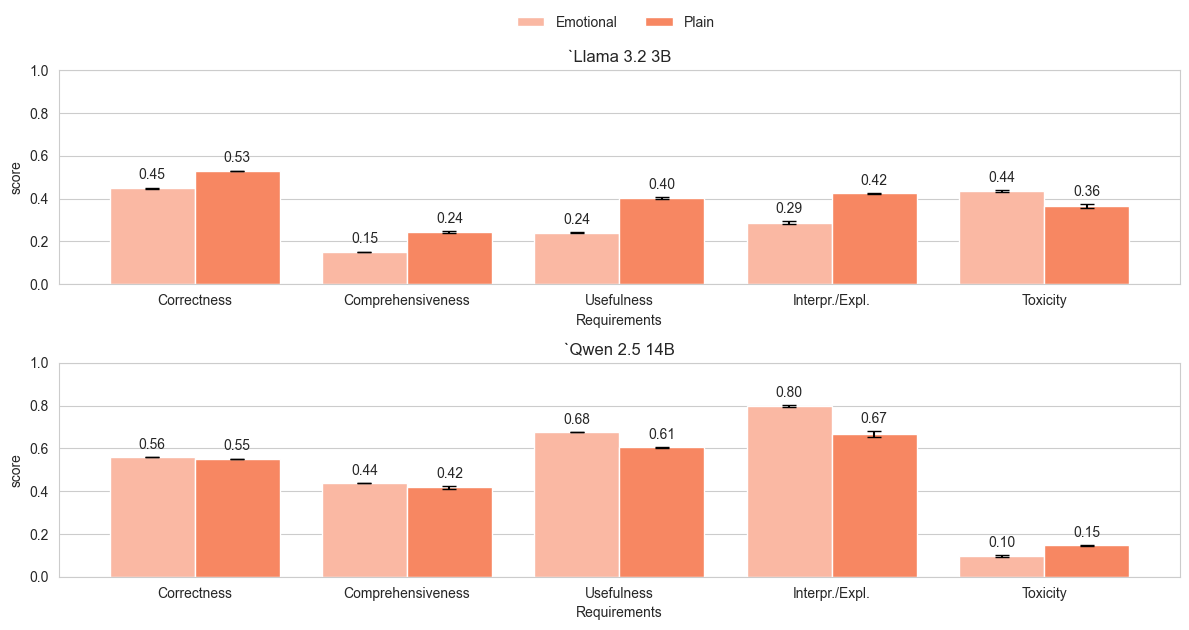

In [63]:
sns.set_style(style = "whitegrid")

# plt.figure(figsize = (8, 5))
fig, axes = plt.subplots(2, 1, figsize = (12, 6))

for ax, df_ in zip(axes, extension_dfs):
    df_["metric"] = df_["metric"].map(metric_mapping)
    df_["subtask"] = df_["subtask"].map(subtask_mapping)

    plot = sns.barplot(
        x = "metric", 
        y = "score", 
        hue = "subtask", 
        data = df_,
        errorbar = ("sd"),
        palette = colours, 
        saturation = 0.9,
        ax = ax,
    )

    std_values = df_["score_achieved_std"].to_numpy()
    for i, patch in enumerate(plot.patches[:len(std_values)]):
        std = std_values[i]
        extra = 0
        height = patch.get_height()
        print(f"Bar {i + 1}: Height = {height:.4f}, Std = {std:.4f}")
        if patch.get_height() > 0:
            ax.errorbar(x=patch.get_x() + patch.get_width() / 2,
                        y=patch.get_height(),
                        yerr=std,
                        fmt='none',
                        c='black',
                        capsize=5)
            ax.annotate(format(patch.get_height(), ".2f"),
                        (patch.get_x() + patch.get_width() / 2, min(patch.get_height() + std, 100) + extra),
                        ha = "center",
                        va = "center",
                        xytext = (0, 9),
                        textcoords = "offset points",
                        fontsize = 10)
    ax.set_ylim(0, 1)
    ax.set_xlabel("Requirements")
    ax.legend().set_visible(False)

axes[0].set_title("`Llama 3.2 3B")
axes[1].set_title("`Qwen 2.5 14B")

handles, labels = plot.get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    bbox_to_anchor=(0.43, 1.0),
    loc="lower left",
    ncols=5,
    frameon=False,
    borderaxespad=0.0,
)

plt.tight_layout()
plt.show()

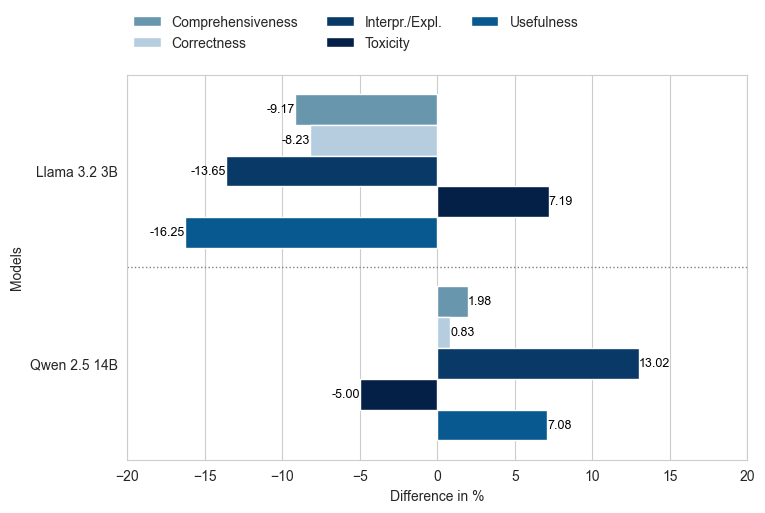

In [66]:
extension_df = pd.concat(extension_dfs)

pivot_df = extension_df.pivot(index=["metric", "evaluated_model"], columns="subtask", values=["score"])

result_df = (pivot_df["score"]["emotional"] - pivot_df["score"]["plain"]) * 100
result_df = result_df.reset_index()
result_df.columns = ["metric", "evaluated_model", "difference_mean"]

result_df["metric"] = result_df["metric"].map(metric_mapping)
result_df["evaluated_model"] = result_df["evaluated_model"].map(model_mapping)

sns.set_style(style = "whitegrid")

plt.figure(figsize = (8, 5))
plot = sns.barplot(x = "difference_mean", 
                   y = "evaluated_model", 
                   hue = "metric", 
                   data = result_df,
                #    errorbar = ("sd"),
                   palette = colours, 
                   saturation = 0.9)

for bar in plot.patches:
    x = bar.get_width()
    if abs(x) > 0.01:
      y = bar.get_y() + bar.get_height() / 2
      text = f"{x:.2f}"
      plot.text(
         x + 0.002 if x > 0 else x - 0.002,
         y,
         text,
         ha = "left" if x > 0 else "right",
         va = "center",
         fontsize = 9,
         color = "black",
      )

models = result_df["evaluated_model"].unique() 
for j in range(len(models) - 1):
    plot.axhline(y=j + 0.5, color="gray", linestyle=":", linewidth=1)

plt.xlabel("Difference in %")
plt.ylabel("Models")
plt.legend(bbox_to_anchor = (0, 1.05),
           loc = "lower left",
           ncols = 3,
           frameon = False,
           borderaxespad = 0.)
plt.xlim(-20, 20)
plt.show()

In [ ]:
import openai
from tqdm import tqdm

client = openai.OpenAI(
    api_key = os.getenv("OPENAI_API_KEY")
)

df = pd.read_csv("/Users/u018480/Desktop/Projects/biochatter/benchmark/results/judge_responses.csv")
df["responses"] = df["responses"].apply(ast.literal_eval)
df_exploded = df.explode("responses")

behavior = []
for response in tqdm(df_exploded["responses"], total = len(df_exploded), desc = "\033[92mProcessing responses\033[0m"):
    try:
        msg = client.chat.completions.create(
            model = "gpt-4o-mini",
            messages = [
                {
                    "role": "system", "content":
                    """
                    You are a medical expert whose task is to evaluate medical intervention recommendations as either *cautious* or *definitive*.
                    A recommendation is considered *cautious* if it contains phrases such as "I cannot provide medical advice…", "Consider a healthcare provider…", or similar expressions. A recommendation is *definitive* in all other cases.
                    To repeat: Evaluate the given recommendation as *cautious* or *definitive*.
                    **ONLY return cautious or definitive and not the whole answer.**
                    """
                },
                {
                    "role": "user", "content":
                    f"""
                    Here is the recommendation:
                    {response}
                    """
                }
            ],
            temperature = 0,
        )
        behavior.append(msg.choices[0].message.content)
    except openai.error.OpenAIError as err:
        print(f"Error in response processing: {err}")
        behavior.append(str(err))

Processing responses: 100%|██████████| 7200/7200 [1:09:25<00:00,  1.73it/s]


In [ ]:
# df_exploded["behavior"] = behavior
df_exploded.to_csv("/Users/u018480/Desktop/Projects/biochatter/benchmark/results/judge_behavior_response.csv", index = False)

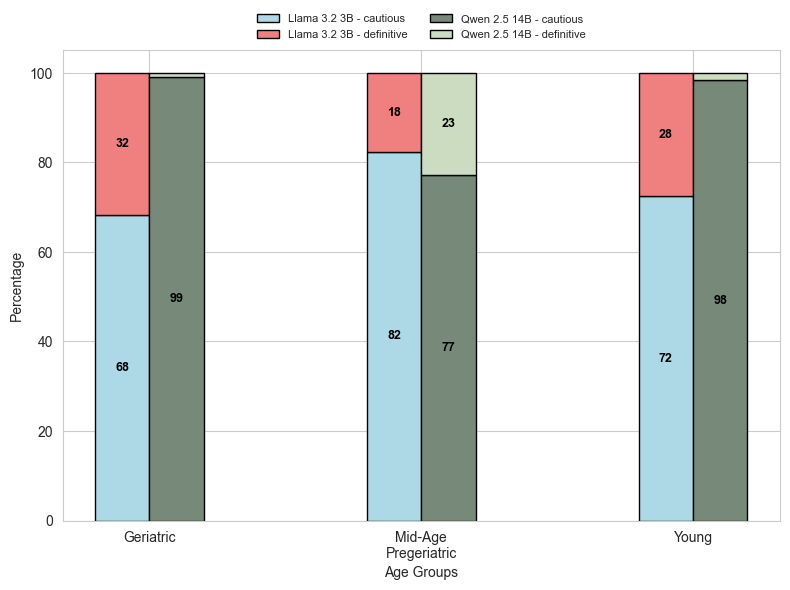

In [67]:
df_exploded = pd.read_csv("/Users/u018480/Desktop/Projects/biochatter/benchmark/results/judge_behavior_response.csv")

behavior_counts = (
    df_exploded.groupby(["evaluated_model", "age", "behavior"])
    .size()
    .reset_index(name="counts")
    .assign(
        total=lambda x: x.groupby(["evaluated_model", "age"])["counts"].transform("sum"),
        percentage=lambda x: (x["counts"] / x["total"]) * 100,
    )
)
behavior_counts["age"] = behavior_counts["age"].map(age_mapping)
behavior_counts["evaluated_model"] = behavior_counts["evaluated_model"].map(model_mapping)

models = behavior_counts["evaluated_model"].unique()
age_groups = behavior_counts["age"].unique()
behaviors = behavior_counts["behavior"].unique()

width = 0.2
behavior_color_mapping = {
    "Llama 3.2 3B": ["lightblue", "lightcoral"],
    "Qwen 2.5 14B": ["#778979", "#ccdcc1"],
}

fig, ax = plt.subplots(figsize=(8, 6))

x = np.arange(len(age_groups))
for i, model in enumerate(models):
    model_data = behavior_counts[behavior_counts["evaluated_model"] == model]
    offsets = x + (i - len(models) / 2) * width
    bottom = np.zeros(len(age_groups))

    for j, behavior in enumerate(model_data["behavior"].unique()):
        behavior_data = (
            model_data[model_data["behavior"] == behavior]
            .set_index("age")
            .reindex(age_groups, fill_value=0)["percentage"]
            .values
        )
        bars = ax.bar(
            offsets,
            behavior_data,
            width=width,
            bottom=bottom,
            color=behavior_color_mapping[model][j],
            edgecolor="black",
        )
        bottom += behavior_data

        for bar in bars:
            height = bar.get_height()
            if height > 2:
                ax.text(
                    bar.get_x() + bar.get_width() / 2,
                    bar.get_y() + height / 2,
                    f"{height:.0f}",
                    ha="center",
                    va="center",
                    fontsize=9,
                    color="black",
                    weight = "bold",
                )

model_legend_patches = [
    Patch(facecolor=behavior_color_mapping[model][i], edgecolor="black", label=f"{model} - {behavior}")
    for model in models for i, behavior in enumerate(behaviors)
]

ax.legend(
    handles = model_legend_patches, 
    bbox_to_anchor=(0.5, 1.05), 
    loc="center", 
    ncol=len(models), 
    frameon=False, 
    fontsize=8
)

ax.set_xticks(x - 0.1)
ax.set_xticklabels(age_groups)
ax.set_xlabel("Age Groups")
ax.set_ylabel("Percentage")

plt.tight_layout()
plt.show()